Epoch 1/30
1695/1695 [==============================] - 68s 37ms/step - loss: 0.0031 - val_loss: 9.5600e-04
Epoch 2/30
1695/1695 [==============================] - 65s 38ms/step - loss: 0.0012 - val_loss: 7.0721e-04
Epoch 3/30
1695/1695 [==============================] - 61s 36ms/step - loss: 9.3869e-04 - val_loss: 4.6082e-04
Epoch 4/30
1695/1695 [==============================] - 63s 37ms/step - loss: 8.1963e-04 - val_loss: 5.1717e-04
Epoch 5/30
1695/1695 [==============================] - 63s 37ms/step - loss: 7.3315e-04 - val_loss: 5.1808e-04
Epoch 6/30
1695/1695 [==============================] - 63s 37ms/step - loss: 6.9521e-04 - val_loss: 5.3964e-04
Epoch 6: early stopping
471/471 [==============================] - 7s 13ms/step
Epoch 1/30
1695/1695 [==============================] - 72s 40ms/step - loss: 0.0033 - val_loss: 9.3580e-04
Epoch 2/30
1695/1695 [==============================] - 62s 37ms/step - loss: 0.0013 - val_loss: 8.5701e-04
Epoch 3/30
1695/1695 [==================

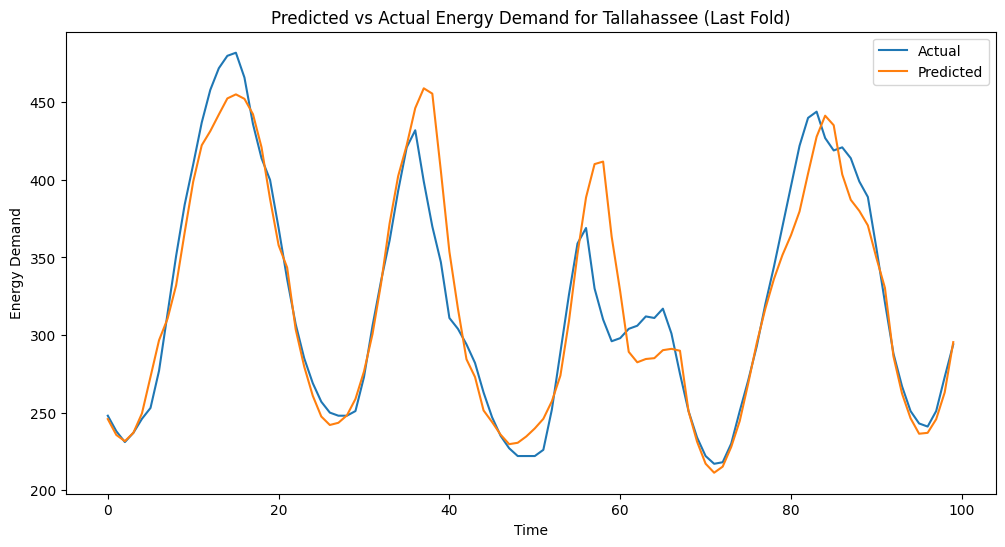

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error


df = pd.read_csv('/content/Tallahassee.csv')
df.dropna(inplace=True)


df['Hour'] = pd.to_datetime(df['time']).dt.hour
df['DayOfWeek'] = pd.to_datetime(df['time']).dt.dayofweek
df['Month'] = pd.to_datetime(df['time']).dt.month
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)


for lag in range(1, 25):
    df[f'Lag_{lag}'] = df['D'].shift(lag)


df['Temp_RollingMean_24'] = df['Temperature'].rolling(window=24).mean()
df['Temp_RollingStd_24'] = df['Temperature'].rolling(window=24).std()


df['Temp_Humidity_Interaction'] = df['Temperature'] * df['RelativeHumidity']


df.dropna(inplace=True)


features = df[['Temperature', 'DewPoint', 'RelativeHumidity', 'Precipitation', 'WindSpeed', 'Pressure',
               'Hour', 'DayOfWeek', 'Month', 'IsWeekend',
               'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Lag_6', 'Lag_7', 'Lag_8', 'Lag_9', 'Lag_10',
               'Lag_11', 'Lag_12', 'Lag_13', 'Lag_14', 'Lag_15', 'Lag_16', 'Lag_17', 'Lag_18', 'Lag_19',
               'Lag_20', 'Lag_21', 'Lag_22', 'Lag_23', 'Lag_24',
               'Temp_RollingMean_24', 'Temp_RollingStd_24',
               'Temp_Humidity_Interaction']].values
energy_demand = df['D'].values.reshape(-1, 1)
dates = df['time'].values


scaler_features = MinMaxScaler()
scaler_energy = MinMaxScaler()
features_normalized = scaler_features.fit_transform(features)
energy_demand_normalized = scaler_energy.fit_transform(energy_demand)


def create_sequences(data, target, dates, seq_length):
    sequences = []
    targets = []
    sequence_dates = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target_seq = target[i+seq_length]
        date_seq = dates[i+seq_length]
        sequences.append(seq)
        targets.append(target_seq)
        sequence_dates.append(date_seq)
    return np.array(sequences), np.array(targets), np.array(sequence_dates)

seq_length = 24
X, y, dates_seq = create_sequences(features_normalized, energy_demand_normalized, dates, seq_length)


kf = KFold(n_splits=5, shuffle=False, random_state=None)

mse_scores = []
mae_scores = []
mape_scores = []

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

result_df = pd.DataFrame()

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    dates_test = dates_seq[test_index]

    model = Sequential([
        GRU(100, activation='tanh', return_sequences=True, input_shape=(seq_length, X.shape[2])),
        Dropout(0.2),
        GRU(50, activation='tanh'),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )


    history = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stopping],
        verbose=1
    )

    loss = model.evaluate(X_test, y_test)

    predictions_normalized = model.predict(X_test)
    predictions = scaler_energy.inverse_transform(predictions_normalized)
    y_test_original = scaler_energy.inverse_transform(y_test)

    mse = mean_squared_error(y_test_original, predictions)
    mae = mean_absolute_error(y_test_original, predictions)
    mape = mean_absolute_percentage_error(y_test_original, predictions)
    mse_scores.append(mse)
    mae_scores.append(mae)
    mape_scores.append(mape)

    fold_results = pd.DataFrame({
        'Date': dates_test,
        'Actual': y_test_original.flatten(),
        'Predicted': predictions.flatten()
    })

    result_df = pd.concat([result_df, fold_results], ignore_index=True)

average_mse = np.mean(mse_scores)
average_mae = np.mean(mae_scores)
average_mape = np.mean(mape_scores)
print(f"Average Mean Squared Error: {average_mse}")
print(f"Average Mean Absolute Error: {average_mae}")
print(f"Average Mean Absolute Percentage Error: {average_mape}")

plt.figure(figsize=(12, 6))
plt.plot(result_df['Actual'][:100], label='Actual')
plt.plot(result_df['Predicted'][:100], label='Predicted')
plt.title('Predicted vs Actual Energy Demand for Tallahassee (Last Fold)')
plt.xlabel('Time')
plt.ylabel('Energy Demand')
plt.legend()
plt.show()